# Assess model performance from pre-trained model

In [1]:
import subprocess
import sys
import os
try:
    import torch_geometric
    print("torch_geometric is already installed.")
except ImportError:
    print("torch_geometric is not installed. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch-geometric"])
    print("torch_geometric has been installed.")

import scipy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import pickle
from generateDeltawing import vehicle_setup, full_setup, point_analysis
import math
import pandas as pd
import json

VortexNet_path = '/home/yiren/Desktop/MF-VortexNet'
sys.path.append(VortexNet_path)
import VortexNet
from VortexNet.MFData import MFData

torch_geometric is already installed.


## Helper functions for plottings

In [2]:
def plot_field_distribution(VD, cp, title='Pressure Distribution', min=None, max=None, ax=None, cbar=False):
    # Ensure cp is a 1D array
    if cp.ndim > 1:
        cp = cp.squeeze(0)

    if min is None:
        vmin = np.min(cp)
    else:
        vmin = min

    if max is None:
        vmax = np.max(cp)
    else:
        vmax = max

    # If no axes are provided, create one
    if ax is None:
        fig, ax = plt.subplots()

    # Normalize the pressure coefficient values to the range [vmin, vmax]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Plot the panels and fill with cp data
    for i in range(len(VD.XA1)):
        x = [VD.XA1[i], VD.XB1[i], VD.XB2[i], VD.XA2[i], VD.XA1[i]]
        y = [VD.YA1[i], VD.YB1[i], VD.YB2[i], VD.YA2[i], VD.YA1[i]]

        # Get the color for the current pressure coefficient value
        cp_value = cp[i]
        color = scalar_map.to_rgba(cp_value)

        # Fill the panel with the corresponding cp value
        polygon = plt.Polygon(np.column_stack((x, y)), closed=True, facecolor=color, edgecolor=(0, 0, 0, 0.1))
        ax.add_patch(polygon)

    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.axis('equal')

    # Return the scalar map for consistent color bar
    if cbar:
        return scalar_map
    return None


# specify the model to import 

In [3]:
weights_name = '20241116_045918'

# Specify the path to the trained weights file
weights_path = "./pretrained_model/model_weights_{}.pth".format(weights_name)
print(weights_path)
hyperparameters_path = "./pretrained_model/tuning_results_{}.json".format(weights_name)
print(hyperparameters_path)

with open(hyperparameters_path) as f:
    optimal_hp = json.load(f)

hyperparameters = optimal_hp['hyperparameters']
hidden_channels = hyperparameters.get('hidden_channels')
learning_rate = hyperparameters.get('learning_rate')
decay = hyperparameters.get('decay')
HEADS = hyperparameters.get('HEADS')
penalty_weight = hyperparameters.get('penalty_weight')
DROP_OUT = hyperparameters.get('dropout_rate')
LAMBDA = hyperparameters.get('LAMBDA')
ALPHA = hyperparameters.get('ALPHA')
HOP = hyperparameters.get('HOP')
max_phy_loss = hyperparameters.get('max_phy_loss')

# print a summary of the hyperparameters
print("******Summary of the Hyperparameters******")
print(f"Hidden channels: {hidden_channels}")
print(f"Learning rate: {learning_rate}")
print(f"Decay: {decay}")
print(f"Heads: {HEADS}")
print(f"Penalty weight: {penalty_weight}")
print(f"Dropout rate: {DROP_OUT}")
print(f"Lambda: {LAMBDA}")
print(f"Alpha: {ALPHA}")
print(f"Number of hops: {HOP}")
print(f"Max physical loss: {max_phy_loss}")


# fixed hyperparameters
noise = 0.02
CLIP_VALUE = 30
node_in_channels = 11
edge_in_channels = 1
out_channels = 1
device = 'cuda'
REF_RE = 10**7
Ref_Length = 0.435762

model = VortexNet.model.GNN4(node_in_channels, edge_in_channels, hidden_channels, out_channels, num_coarse=None, \
             num_fine=None, dropout_rate=DROP_OUT, HEADS = HEADS, ALPHA=ALPHA, HOP=HOP ).to(device)

model.load_state_dict(torch.load(weights_path))

print("***Model loaded from \n {}".format(weights_path))


# load test data 
directory_path = './dataset/train_set'
print(f"Loading data from {directory_path}")
mf_results = VortexNet.VortexNetUtils.load_pickle_data(directory_path)
print(f"Total number of runs: {len(mf_results)}")

for i in range(len(mf_results)):
    print(f"Run {i+1}: {mf_results[i].geom}")

train_set, test_set = VortexNetUtils.split_mfdata(mf_results, test_size=0.3, random_seeds=21)

# Assemble training and test datasets
training_data = VortexNetUtils.assemble_dataset(train_set, REF_RE)
test_data = VortexNetUtils.assemble_dataset(test_set, REF_RE)
# Prepare the training dataset
nn_training_set = [
    VortexNetUtils.prepare_dataset_with_standarization(
        cp, vlm_cp, cfd_cp, thickness, curvature_u, curvature_l,
        slope_u, slope_l, ff, aic_matrix, rhs_matrix, dcpsid, 
        factor, chord, rnmax
    )
    for cp, vlm_cp, cfd_cp, thickness, curvature_u, curvature_l, slope_u, slope_l, ff, aic_matrix, 
        rhs_matrix, dcpsid, factor, chord, rnmax in zip(
        training_data["control_points"], training_data["vlm_dcp"], training_data["cfd_dcp"],
        training_data["vlm_thickness"], training_data["vlm_curvature_u"], training_data["vlm_curvature_l"],
        training_data["vlm_slope_chord_u"], training_data["vlm_slope_chord_l"], 
        training_data["cfd_ff"], training_data["aic_matrices"], training_data["rhs_matrices"],
        training_data["dcpsid_list"], training_data["factor_list"], training_data["chord_list"],
        training_data["rnmax_list"]
    )
]

# Prepare the test dataset
nn_test_set = [
    VortexNetUtils.prepare_dataset_with_standarization(
        cp, vlm_cp, cfd_cp, thickness, curvature_u, curvature_l, slope_u, slope_l, ff,
        aic_matrix, rhs_matrix, dcpsid, factor, chord, rnmax
    )
    for cp, vlm_cp, cfd_cp, thickness, curvature_u, curvature_l, slope_u, slope_l, ff, aic_matrix, 
        rhs_matrix, dcpsid, factor, chord, rnmax in zip(
        test_data["control_points"], test_data["vlm_dcp"], test_data["cfd_dcp"],
        test_data["vlm_thickness"], test_data["vlm_curvature_u"], test_data["vlm_curvature_l"],
        test_data["vlm_slope_chord_u"], test_data["vlm_slope_chord_l"],
        test_data["cfd_ff"], test_data["aic_matrices"], test_data["rhs_matrices"],
        test_data["dcpsid_list"], test_data["factor_list"], test_data["chord_list"],
        test_data["rnmax_list"]
    )
]

# Print summary of the training and test set 
print("******Summary of the Training and Test Datasets******")
print(f"Number of training samples: {len(nn_training_set)}")
print(f"Number of test samples: {len(nn_test_set)}")
print(f"Number of features: {nn_training_set[0].num_features}")
print(f"Number of edge features: {nn_training_set[0].num_edge_features}")
print(f"Number of nodes: {nn_training_set[0].num_nodes}")
print(f"Number of edges: {nn_training_set[0].num_edges}")


model.eval()




./pretrained_model/model_weights_20241116_045918.pth
./pretrained_model/tuning_results_20241116_045918.json


FileNotFoundError: [Errno 2] No such file or directory: './pretrained_model/tuning_results_20241116_045918.json'

Test loss: 0.0369
(900,)
Test 22 Predicted, AoA: 16.4, Mach: 0.47 dcp
Re: 9.78e+06


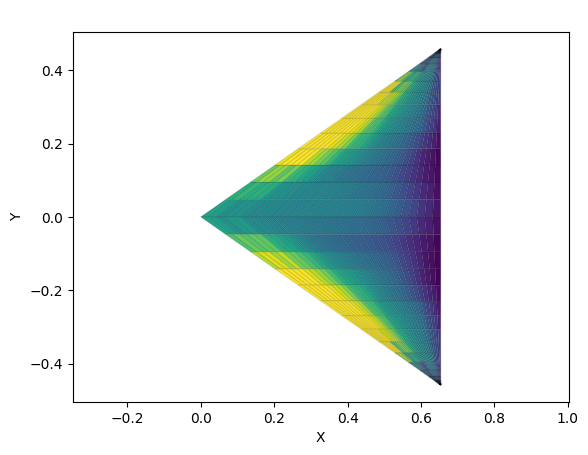

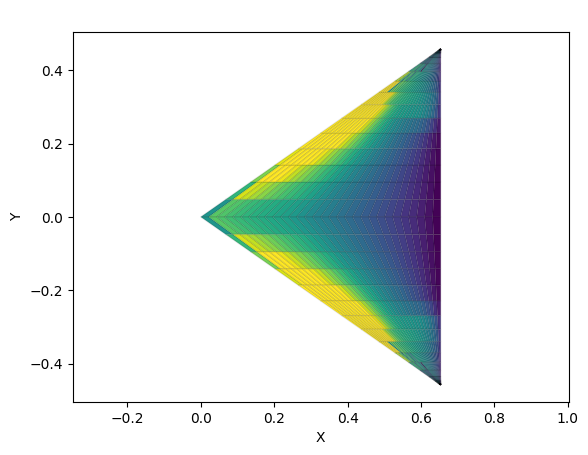

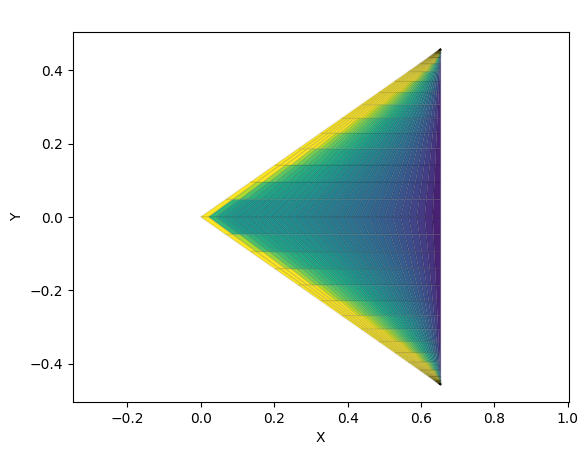

In [4]:
# Evaluate the model on the test set
test_loss = 0
for data in nn_test_set:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        test_loss += F.mse_loss(output, data.y).item()

test_loss /= len(test_set)
print(f'Test loss: {test_loss:.4f}')
# Plot the results for a random index
test_index = np.random.randint(len(test_set))
test_index = 22
data = nn_test_set[test_index].to(device)

with torch.no_grad():
    output = model(data).cpu().numpy().reshape(-1)
    print(output.shape)
    print(f"Test {test_index} Predicted, AoA: {test_set[test_index].alpha}, Mach: {test_set[test_index].mach} dcp")
    plot_field_distribution(test_set[test_index].vlm_vd, np.array(output), 
                            title=f" ",
                            min=0, max=1.5)
    plot_field_distribution(test_set[test_index].vlm_vd, np.array(test_set[test_index].cfd_data),
                            title=f" ",
                            min=0, max=1.5)
    plot_field_distribution(test_set[test_index].vlm_vd, np.array(test_set[test_index].vlm_data),
                            title=f" ",
                            min=0, max=1.5)
    print(f"Re: {test_set[test_index].Re:.2e}")

In [5]:
# sweep over all cases and use the predicted DCP to calculate Cl Cm and Cd

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import SUAVE


# loop over all test cases to get the results
AOA = -8.79
Ma = 0.4
DCP = mf_results[0].vlm_data
SPC = 0.0

def integrate_fois(AOA, Ma, DCP, SPC, SWEEP, NACA4DIGITS):
    configs, analyses = full_setup(SWEEP, NACA4DIGITS)
    configs.finalize()
    analyses.finalize()
    vehicle = vehicle_setup(SWEEP, NACA4DIGITS)
    # base analysis
    results = point_analysis(vehicle, AOA, Ma, 
                             SWEEP, NACA4DIGITS,
                            if_plot=False, 
                            DCP_overwrite= DCP, 
                            SPC_enforce = SPC)
    
    CL = results.CL[0][0]
    CD = results.CDi[0][0]
    CM = results.CM[0][0]
    return CL, CD, CM
vlm_cl = []
vlm_cd = []
vlm_cm = []
cfd_cl = []
cfd_cd = []
cfd_cm = []
maped_cfd_cl = []
maped_cfd_cd = []
maped_cfd_cm = []
nn_cl = []
nn_cd = []
nn_cm = []
aoa = []
Mach = []
Re = []
all_sweep = []
all_naca = []

nn_total_set = nn_training_set + nn_test_set
total_set = train_set + test_set

for i in range(len(total_set)):
    AOA = total_set[i].alpha
    Ma = total_set[i].mach
    iRe = total_set[i].Re
    SWEEP = total_set[i].geom[0]
    NACA4DIGITS = total_set[i].geom[1]
    #print(f"Run {i+1}: AOA: {AOA}, Ma: {Ma}, Re: {iRe}, SWEEP: {SWEEP}, NACA4DIGITS: {NACA4DIGITS}")
    # put VLM results to store
    vlm_dcp = total_set[i].vlm_data
    icl, icd, icm = integrate_fois(AOA, Ma, vlm_dcp, SPC, SWEEP, NACA4DIGITS)
    # put VLM results to store
    vlm_cl.append(icl)
    vlm_cd.append(icd)
    vlm_cm.append(icm)

    # calculate mapped CFD results
    DCP = np.array(total_set[i].cfd_data).reshape(1,-1)
    SPC = -0
    cl, cd, cm = integrate_fois(AOA, Ma, DCP, SPC, SWEEP, NACA4DIGITS)
    maped_cfd_cl.append(cl)
    maped_cfd_cd.append(cd)
    maped_cfd_cm.append(cm)

    # calculate nn results
    data = nn_total_set[i].to(device)
    with torch.no_grad():
        output = model(data).cpu().numpy()
        SPC = -1
        pred_cl, pred_cd, pred_cm = integrate_fois(AOA, Ma, output.T, SPC, SWEEP, NACA4DIGITS)
        nn_cl.append(pred_cl)
        nn_cd.append(pred_cd)
        nn_cm.append(pred_cm)

    aoa.append(AOA)
    Mach.append(Ma)
    Re.append(iRe)

    # append the sweep and naca
    all_sweep.append(SWEEP)
    all_naca.append(NACA4DIGITS)
    






# Convert lists to numpy arrays for easier manipulation
aoa_np = np.array(aoa)
mach_np = np.array(Mach)
re_np = np.array(Re)
vlm_cl_np = np.array(vlm_cl)
maped_cfd_cl_np = np.array(maped_cfd_cl)
nn_cl_np = np.array(nn_cl)
vlm_cd_np = np.array(vlm_cd)
maped_cfd_cd_np = np.array(maped_cfd_cd)
nn_cd_np = np.array(nn_cd)
vlm_cm_np = np.array(vlm_cm)
maped_cfd_cm_np = np.array(maped_cfd_cm)
nn_cm_np = np.array(nn_cm)

# Create a grid for surface fitting
aoa_grid, mach_grid = np.meshgrid(np.linspace(-15, 25, 100),
                                  np.linspace(0.35, 0.75, 100))

# Function to fit and plot surfaces
def plot_with_surface(ax, mach_np, aoa_np, vlm_data_np, maped_cfd_data_np, nn_data_np, label_vlm, label_cfd, label_nn, zlabel):
    # VLM surface fitting using nearest neighbor method
    vlm_surface = griddata((mach_np, aoa_np), vlm_data_np, (mach_grid, aoa_grid), method='linear')
    # Mapped CFD surface fitting using nearest neighbor method
    maped_cfd_surface = griddata((mach_np, aoa_np), maped_cfd_data_np, (mach_grid, aoa_grid), method='linear')
    # NN surface fitting using nearest neighbor method
    nn_surface = griddata((mach_np, aoa_np), nn_data_np, (mach_grid, aoa_grid), method='nearest')

    # Scatter plot
    ax.scatter(mach_np, aoa_np, vlm_data_np, label=label_vlm, c='b')
    ax.scatter(mach_np, aoa_np, maped_cfd_data_np, label=label_cfd, c='r')
    ax.scatter(mach_np, aoa_np, nn_data_np, label=label_nn, c='g')

    # Plot surfaces
    ax.plot_surface(mach_grid, aoa_grid, vlm_surface, color='blue', alpha=0.3)
    ax.plot_surface(mach_grid, aoa_grid, maped_cfd_surface, color='red', alpha=0.3)
    ax.plot_surface(mach_grid, aoa_grid, nn_surface, color='green', alpha=0.3)

    # Labels and title
    ax.set_xlabel('Mach Number')
    ax.set_ylabel('AOA [deg]')
    ax.set_zlabel(zlabel)
    ax.legend()



import plotly.graph_objs as go
import numpy as np

# Function to create interactive 3D plots with surfaces
def plot_with_surface_plotly(x, y, z_vlm, z_cfd, z_nn, re_np, title, zlabel):
    # Create the VLM scatter plot
    trace_vlm = go.Scatter3d(
        x=x,
        y=y,
        z=z_vlm,
        mode='markers',
        marker=dict(
            size=3,
            color=re_np,
            symbol='circle-open',
            colorscale='Viridis',  # You can choose any colorscale you like
            colorbar=dict(title='Reynolds Number'),
            showscale=True  # Show color scale for this trace
        ),
        name='VLM'
    )

    # Create the Mapped CFD scatter plot
    trace_cfd = go.Scatter3d(
        x=x,
        y=y,
        z=z_cfd,
        mode='markers',
        marker=dict(
            size=3,
            color=re_np,
            symbol='diamond',
            colorscale='Viridis',
            showscale=False  # Hide color scale to avoid duplication
        ),
        name='Mapped CFD'
    )

    # Create the NN scatter plot
    trace_nn = go.Scatter3d(
        x=x,
        y=y,
        z=z_nn,
        mode='markers',
        marker=dict(
            size=3,
            color=re_np,
            colorscale='Viridis',
            showscale=False  # Hide color scale to avoid duplication
        ),
        name='NN Prediction'
    )

    # Define the layout
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='Mach Number'),
            yaxis=dict(title='AOA [deg]'),
            zaxis=dict(title=zlabel) ),
        margin=dict(l=0, r=0, b=0, t=50),
        # Adjust the overall layout to make space for the colorbar
        height=700,
    )
    

    return [trace_vlm, trace_cfd, trace_nn], layout

# Generate the 3D plots
fig_cl = go.Figure(
    data=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cl_np, maped_cfd_cl_np, nn_cl_np, re_np, 'Cl Comparison', 'Cl'
    )[0],
    layout=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cl_np, maped_cfd_cl_np, nn_cl_np, re_np, 'Cl Comparison', 'Cl'
    )[1]
)

fig_cd = go.Figure(
    data=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cd_np, maped_cfd_cd_np, nn_cd_np, re_np, 'Cd Comparison', 'Cd'
    )[0],
    layout=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cd_np, maped_cfd_cd_np, nn_cd_np, re_np, 'Cd Comparison', 'Cd'
    )[1]
)

fig_cm = go.Figure(
    data=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cm_np, maped_cfd_cm_np, nn_cm_np, re_np, 'Cm Comparison', 'Cm'
    )[0],
    layout=plot_with_surface_plotly(
        mach_np, aoa_np, vlm_cm_np, maped_cfd_cm_np, nn_cm_np, re_np, 'Cm Comparison', 'Cm'
    )[1]
)

# Display the plots
fig_cl.show()
fig_cd.show()
fig_cm.show()




Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memor

In [6]:
from sklearn.metrics import r2_score


# Calculate the MSE and R2 for the training set
train_loss = 0
train_targets = []
train_predictions = []

for data in nn_training_set:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        train_predictions.append(output.cpu().numpy())
        train_targets.append(data.y.cpu().numpy())
        train_loss += F.mse_loss(output, data.y).item()

train_loss /= len(nn_training_set)
train_targets = np.concatenate(train_targets, axis=0)
train_predictions = np.concatenate(train_predictions, axis=0)
train_r2 = r2_score(train_targets, train_predictions)

# Calculate the MSE and R2 for the test set
test_loss = 0
test_targets = []
test_predictions = []

for data in nn_test_set:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        test_predictions.append(output.cpu().numpy())
        test_targets.append(data.y.cpu().numpy())
        test_loss += F.mse_loss(output, data.y).item()

test_loss /= len(nn_test_set)
test_targets = np.concatenate(test_targets, axis=0)
test_predictions = np.concatenate(test_predictions, axis=0)
test_r2 = r2_score(test_targets, test_predictions)

# Calculate the MSE and R2 for the entire dataset
total_loss = 0
total_targets = []
total_predictions = []

for data in nn_total_set:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        total_predictions.append(output.cpu().numpy())
        total_targets.append(data.y.cpu().numpy())
        total_loss += F.mse_loss(output, data.y).item()

total_loss /= len(nn_total_set)
total_targets = np.concatenate(total_targets, axis=0)
total_predictions = np.concatenate(total_predictions, axis=0)
total_r2 = r2_score(total_targets, total_predictions)

# Print results
print(f'Training loss (MSE): {train_loss:.4f}, R2: {train_r2:.4f}')
print(f'Test loss (MSE): {test_loss:.4f}, R2: {test_r2:.4f}')
print(f'Total loss (MSE): {total_loss:.4f}, R2: {total_r2:.4f}')




Training loss (MSE): 0.0377, R2: 0.8382
Test loss (MSE): 0.0369, R2: 0.8410
Total loss (MSE): 0.0374, R2: 0.8391


# plot prediction error 

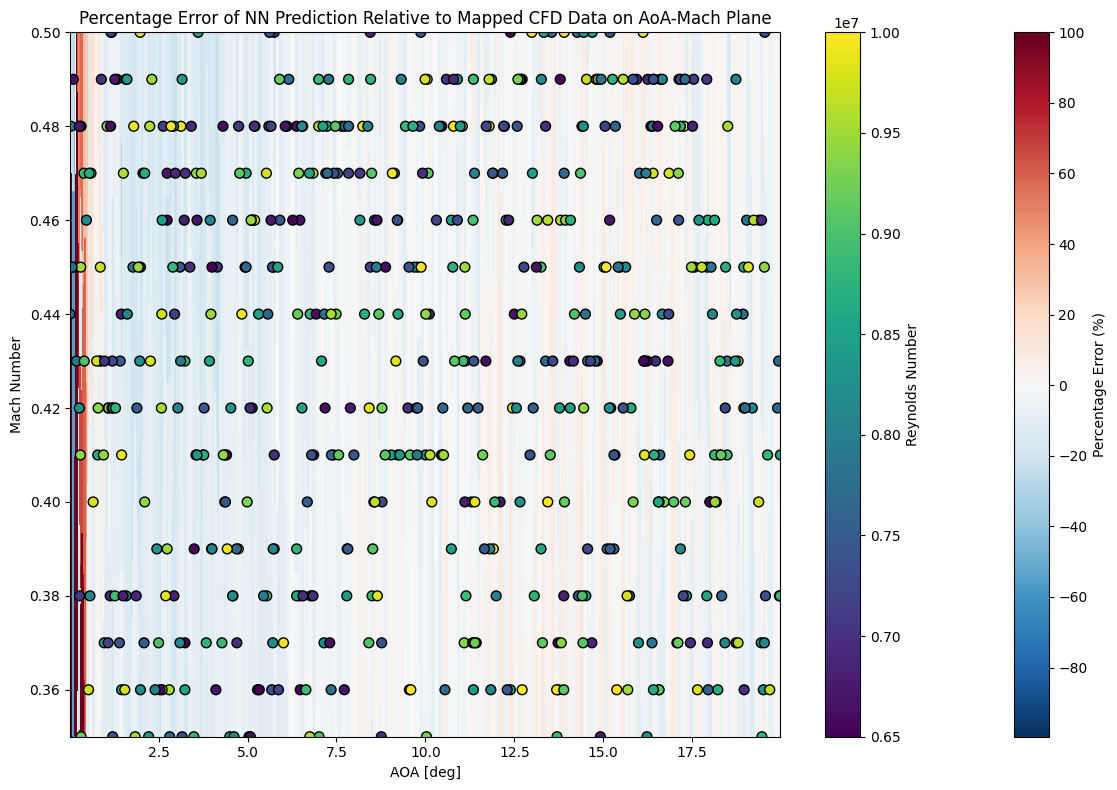

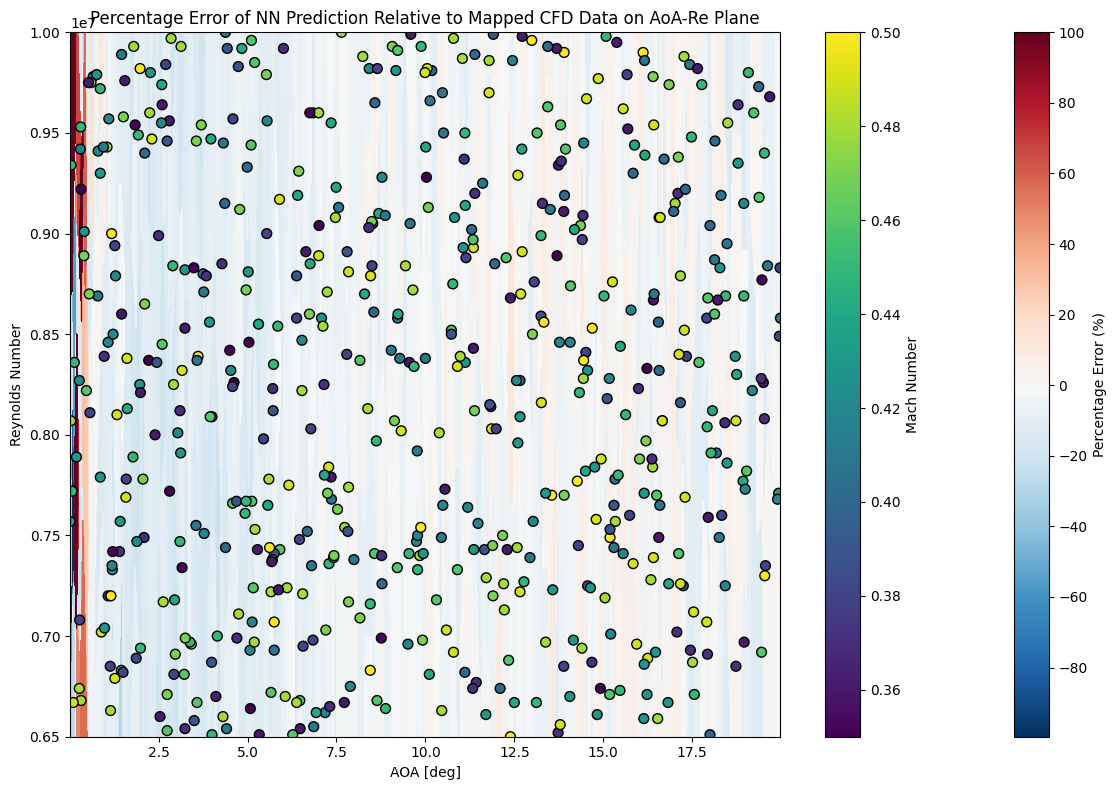

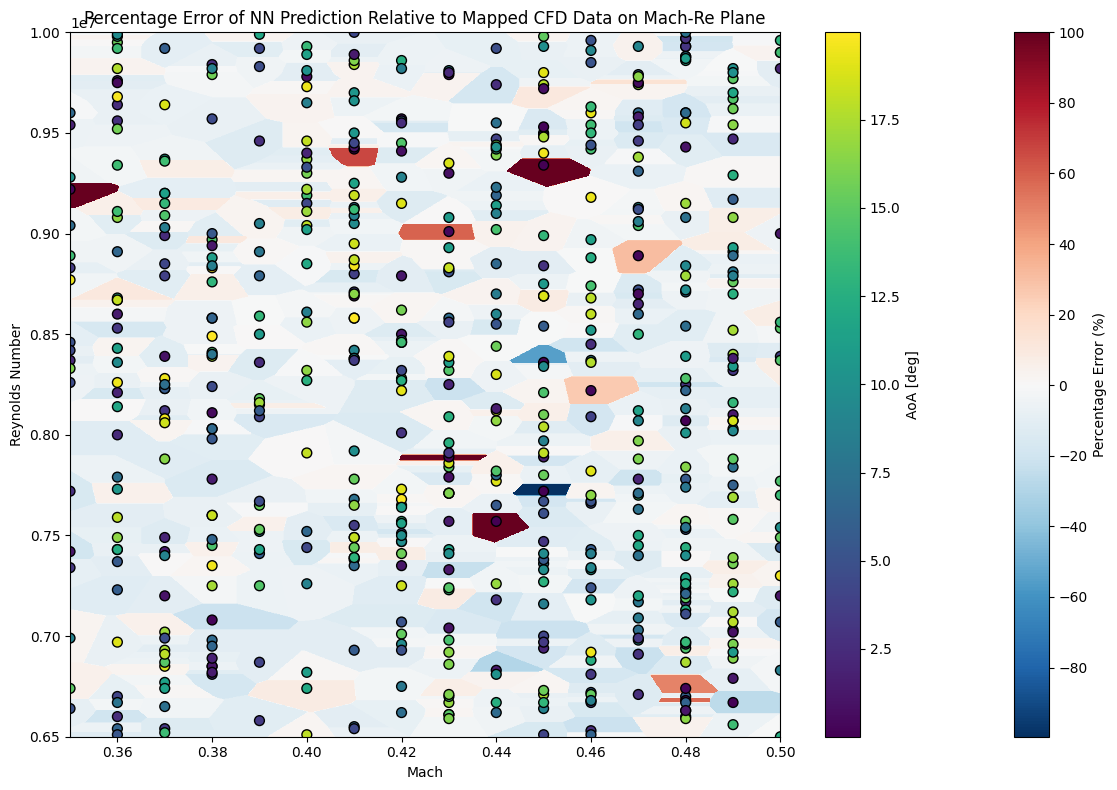

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Compute the percentage error
percentage_error = 100 * (nn_cm_np - maped_cfd_cm_np) / maped_cfd_cm_np

# Limit the percentage error to ±300%
percentage_error = np.clip(percentage_error, -100, 100)

# Define the grid over AOA and Mach for interpolation
num_aoa_points = 1000  
num_mach_points = 1000
mum_re_points = 1000

aoa_grid = np.linspace(aoa_np.min(), aoa_np.max(), num_aoa_points)
mach_grid = np.linspace(mach_np.min(), mach_np.max(), num_mach_points)
re_grid = np.linspace(re_np.min(), re_np.max(), mum_re_points)

AOA_grid, Mach_grid = np.meshgrid(aoa_grid, mach_grid)

# Interpolate the percentage error over the grid
grid_percentage_error = griddata(
    (aoa_np, mach_np), percentage_error, (AOA_grid, Mach_grid), method='nearest'
)

# Handle any NaN values resulting from interpolation
grid_percentage_error = np.ma.array(grid_percentage_error, mask=np.isnan(grid_percentage_error))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the interpolated percentage error using contourf
contour = plt.contourf(
    AOA_grid, Mach_grid, grid_percentage_error, levels=500, cmap='RdBu_r', vmin=-100, vmax=100
)
cbar = plt.colorbar(contour, label='Percentage Error (%)')

# Overlay scatter points of the data, colored by Reynolds number
scatter = plt.scatter(aoa_np, mach_np, c=re_np, cmap='viridis', edgecolors='k', s=50)
cbar_re = plt.colorbar(scatter, label='Reynolds Number')

# Set labels and title
plt.xlabel('AOA [deg]')
plt.ylabel('Mach Number')
plt.title('Percentage Error of NN Prediction Relative to Mapped CFD Data on AoA-Mach Plane')

# Show the plot
plt.tight_layout()
plt.show()


## result for AOA-RE plane 
re_np_scaled = re_np / 1e7
aoa_grid = np.linspace(aoa_np.min(), aoa_np.max(), num_aoa_points)
re_grid_scaled = np.linspace(re_np_scaled.min(), re_np_scaled.max(), mum_re_points)

AOA_grid, Re_grid = np.meshgrid(aoa_grid, re_grid_scaled)
grid_percentage_error = griddata(
    (aoa_np, re_np_scaled), percentage_error, (AOA_grid, Re_grid), method='nearest'
)

grid_percentage_error = np.ma.array(grid_percentage_error, mask=np.isnan(grid_percentage_error))
plt.figure(figsize=(12, 8))
contour = plt.contourf(
    AOA_grid, Re_grid * 1e7, grid_percentage_error, levels=500, cmap='RdBu_r', vmin=-100, vmax=100
)
cbar = plt.colorbar(contour, label='Percentage Error (%)')
scatter = plt.scatter(aoa_np, re_np, c=mach_np, cmap='viridis', edgecolors='k', s=50)
cbar_re = plt.colorbar(scatter, label='Mach Number')
plt.xlabel('AOA [deg]')
plt.ylabel('Reynolds Number')
plt.title('Percentage Error of NN Prediction Relative to Mapped CFD Data on AoA-Re Plane')
plt.tight_layout()
plt.show()

## result for Mach-Re Plane 

Mach_grid, Re_grid = np.meshgrid(mach_grid, re_grid_scaled)
grid_percentage_error = griddata(
    (mach_np, re_np_scaled), percentage_error, (Mach_grid, Re_grid), method='nearest'
)

grid_percentage_error = np.ma.array(grid_percentage_error, mask=np.isnan(grid_percentage_error))
plt.figure(figsize=(12, 8))
contour = plt.contourf(
    Mach_grid, Re_grid *1e7, grid_percentage_error, levels=500, cmap='RdBu_r', vmin=-100, vmax=100
)
cbar = plt.colorbar(contour, label='Percentage Error (%)')
scatter = plt.scatter(mach_np, re_np, c=aoa_np, cmap='viridis', edgecolors='k', s=50)
cbar_re = plt.colorbar(scatter, label='AoA [deg]')
plt.xlabel('Mach')
plt.ylabel('Reynolds Number')
plt.title('Percentage Error of NN Prediction Relative to Mapped CFD Data on Mach-Re Plane')
plt.tight_layout()
plt.show()


In [8]:
# assessing the prediction quality

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(nn_cm_np, maped_cfd_cm_np))
# Coefficient of Determination (R^2)
r2 = r2_score(nn_cm_np, maped_cfd_cm_np)
# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(nn_cm_np, maped_cfd_cm_np)
# Spearman's Rank Correlation Coefficient
spearman_corr, _ = spearmanr(nn_cm_np, maped_cfd_cm_np)



vlm_cl = []
vlm_cd = []
vlm_cm = []
cfd_cl = []
cfd_cd = []
cfd_cm = []
maped_cfd_cl = []
maped_cfd_cd = []
maped_cfd_cm = []
nn_cl = []
nn_cd = []
nn_cm = []
aoa = []
Mach = []
Re = []



for i in range(len(test_set)):

    AOA = test_set[i].alpha
    Ma = test_set[i].mach
    iRe = test_set[i].Re
    SWEEP = test_set[i].geom[0]
    NACA4DIGITS = test_set[i].geom[1]
    
    
    # put VLM results to store
    vlm_cl.append(test_set[i].vlm_cl)
    vlm_cd.append(test_set[i].vlm_cd)
    vlm_cm.append(test_set[i].vlm_cm)

    # calculate mapped CFD results
    DCP = np.array(test_set[i].cfd_data).reshape(1,-1)
    SPC = 0.0
    cl, cd, cm = integrate_fois(AOA, Ma, DCP, SPC, SWEEP, NACA4DIGITS)
    maped_cfd_cl.append(cl)
    maped_cfd_cd.append(cd)
    maped_cfd_cm.append(cm)

    # calculate nn results
    data = nn_test_set[i].to(device)
    with torch.no_grad():
        output = model(data).cpu().numpy()
        SPC = 0.0
        pred_cl, pred_cd, pred_cm = integrate_fois(AOA, Ma, output.T, SPC, SWEEP, NACA4DIGITS)
        nn_cl.append(pred_cl)
        nn_cd.append(pred_cd)
        nn_cm.append(pred_cm)

    aoa.append(AOA)
    Mach.append(Ma)
    Re.append(iRe)






# Convert lists to numpy arrays for easier manipulation
aoa_np = np.array(aoa)
mach_np = np.array(Mach)
re_np = np.array(Re)
vlm_cl_np = np.array(vlm_cl)
maped_cfd_cl_np = np.array(maped_cfd_cl)
nn_cl_np = np.array(nn_cl)
vlm_cd_np = np.array(vlm_cd)
maped_cfd_cd_np = np.array(maped_cfd_cd)
nn_cd_np = np.array(nn_cd)
vlm_cm_np = np.array(vlm_cm)
maped_cfd_cm_np = np.array(maped_cfd_cm)
nn_cm_np = np.array(nn_cm)

# Root Mean Squared Error
rmse2 = np.sqrt(mean_squared_error(nn_cm_np, maped_cfd_cm_np))
# Coefficient of Determination (R^2)
r22 = r2_score(nn_cm_np, maped_cfd_cm_np)
# Pearson Correlation Coefficient
pearson_corr2, _ = pearsonr(nn_cm_np, maped_cfd_cm_np)
# Spearman's Rank Correlation Coefficient
spearman_corr2, _ = spearmanr(nn_cm_np, maped_cfd_cm_np)




# entire set
print(f"*** Entire Dataset ***")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
# test set
print("***Test Set***")
print(f"RMSE: {rmse2}")
print(f"R^2: {r22}")
print(f"Pearson Correlation: {pearson_corr2}")
print(f"Spearman Correlation: {spearman_corr2}")



Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memory
VSP import failed
Reseting OpenVSP Model in Memor

KeyboardInterrupt: 

# access the latent infor in the network.

Test index: 22
latent dtype: torch.float32
cluster_mask dtype: torch.float32
Original Reconstruction Error: 0.0315
Modified Reconstruction Error: 0.1656
Test 22 Predicted, with truncated latent layer 0 cluster 0 dcp
latent dtype: torch.float32
cluster_mask dtype: torch.float32
Original Reconstruction Error: 0.0315
Modified Reconstruction Error: 0.1626
Test 22 Predicted, with truncated latent layer 0 cluster 1 dcp
latent dtype: torch.float32
cluster_mask dtype: torch.float32
Original Reconstruction Error: 0.0315
Modified Reconstruction Error: 0.0872
Test 22 Predicted, with truncated latent layer 0 cluster 2 dcp
latent dtype: torch.float32
cluster_mask dtype: torch.float32
Original Reconstruction Error: 0.0315
Modified Reconstruction Error: 0.1796
Test 22 Predicted, with truncated latent layer 0 cluster 3 dcp
latent dtype: torch.float32
cluster_mask dtype: torch.float32
Original Reconstruction Error: 0.0315
Modified Reconstruction Error: 0.0943
Test 22 Predicted, with truncated latent la

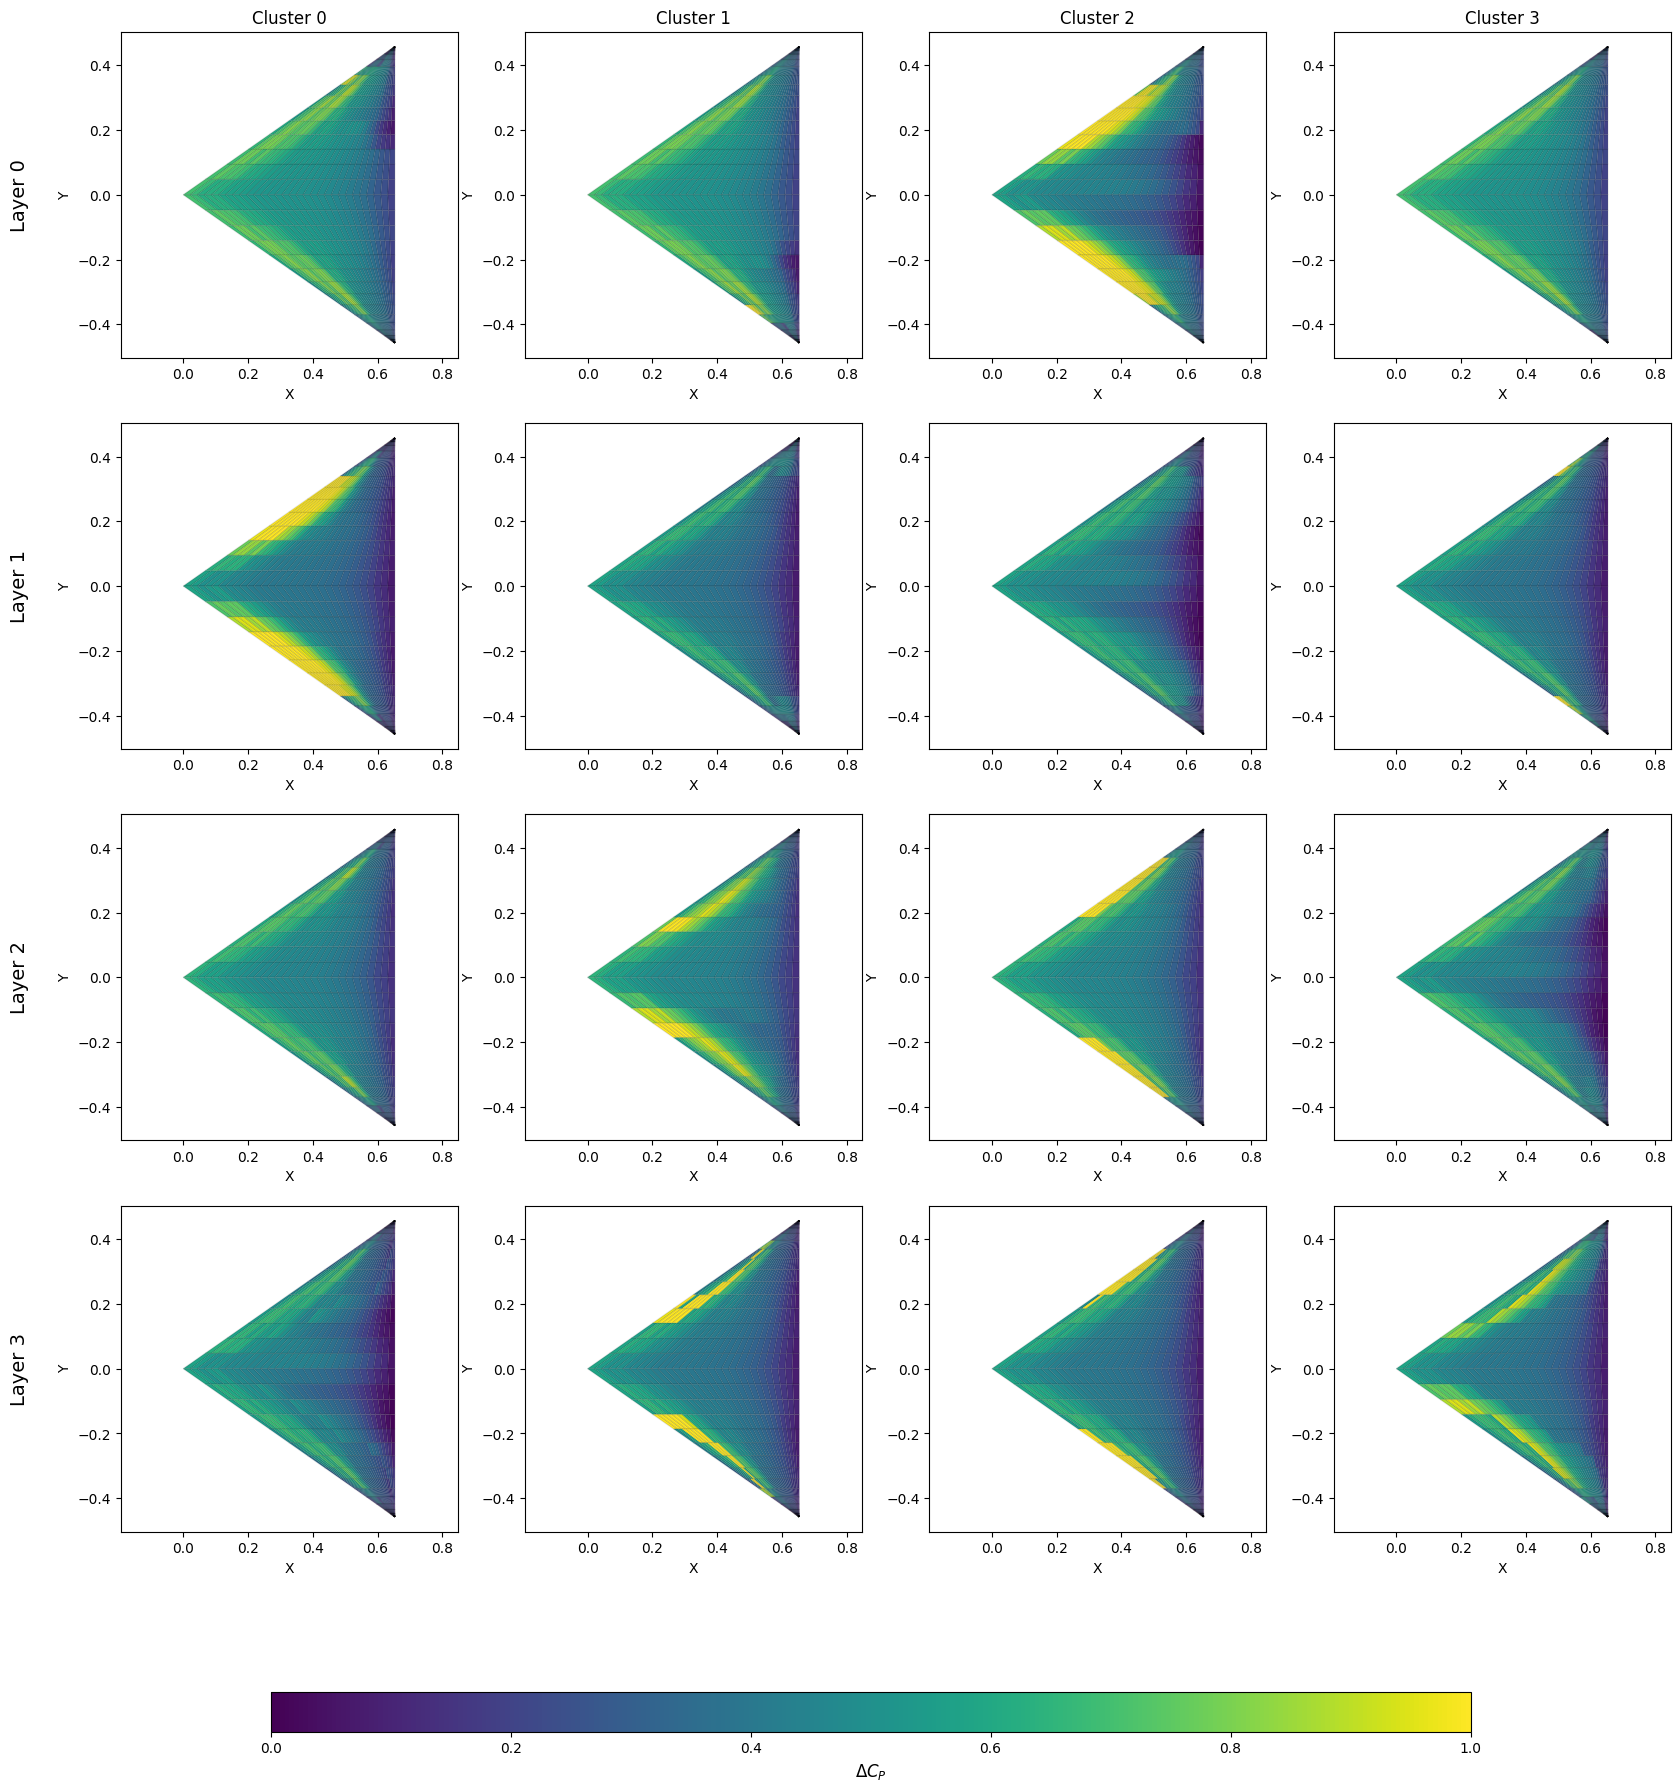

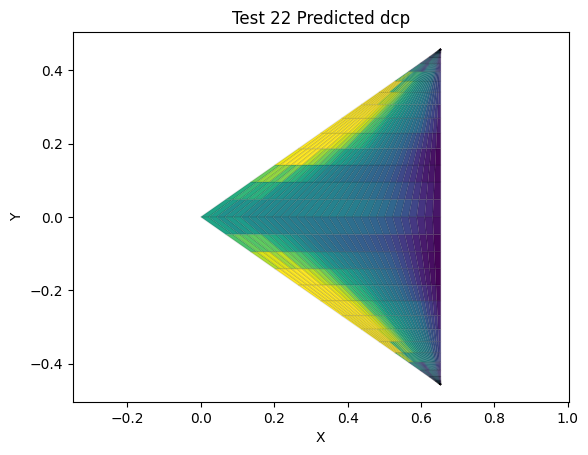

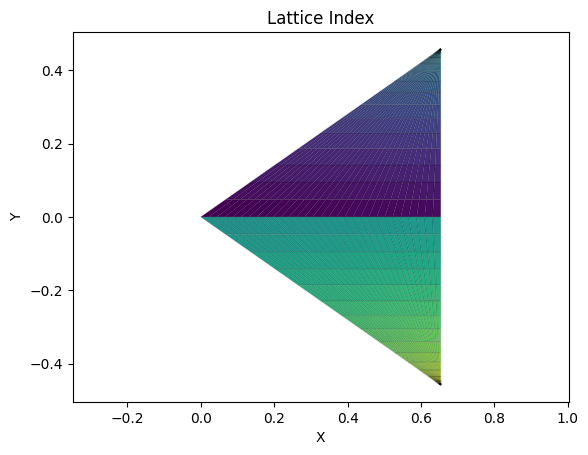

In [ ]:
import plotly.express as px
from sklearn.cluster import KMeans




test_index = 22
print(f"Test index: {test_index}")

data = nn_test_set[test_index].to(device)

model.eval()
with torch.no_grad():
    original_output, latent_representations = model(data, return_latent_space=True)

num_clusters = 4

difference_storage = []
difference_x_label = []

fig, axes = plt.subplots(len(latent_representations), num_clusters, figsize=(20, 5 * len(latent_representations)), constrained_layout=True)
fig.subplots_adjust(bottom=0.15, top=0.90, hspace=0.2, wspace=0.2)  # Adjust spacing

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # Define a single colorbar at the bottom


# Add labels for layer indices on the left
for ilayer in range(len(latent_representations)):
    axes[ilayer, 0].annotate(f"Layer {ilayer}",
                             xy=(-0.3, 0.5), xycoords="axes fraction",
                             fontsize=14, ha="center", va="center", rotation=90)
    
for ilayer in range(len(latent_representations)):
    layer_to_modify = ilayer
    latent = latent_representations[layer_to_modify]

    # Perform clustering
    latent_np = latent.cpu().numpy()
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(latent_np)
    for icluster in range(num_clusters):
        # Isolate desired clusters
        clusters_to_keep = icluster
        cluster_mask = np.isin(clusters, clusters_to_keep).astype(np.float32)  # Ensure float32
        cluster_mask = torch.tensor(cluster_mask, device=latent.device, dtype=latent.dtype).unsqueeze(1)

        # Verify data types
        print(f"latent dtype: {latent.dtype}")
        print(f"cluster_mask dtype: {cluster_mask.dtype}")

        # Apply the mask
        modified_latent = latent * cluster_mask

        # Pass the modified latent representation through the model
        with torch.no_grad():
            modified_output = model(data, modify_latent=True, layer_to_modify=layer_to_modify, modified_latent=modified_latent)

        original_error = torch.mean((data.y - original_output) ** 2).item()
        modified_error = torch.mean((data.y - modified_output) ** 2).item()

        print(f"Original Reconstruction Error: {original_error:.4f}")
        print(f"Modified Reconstruction Error: {modified_error:.4f}")

        # Visualize differences
        original_output_np = original_output.cpu().numpy()
        modified_output_np = modified_output.cpu().numpy()
        difference = np.abs(modified_output_np -original_output_np) / np.abs(original_output_np)

        difference_storage.append(difference)
        difference_x_label.append(10*ilayer + icluster)

        # plot field distribution
        print(f"Test {test_index} Predicted, with truncated latent layer {ilayer} cluster {icluster} dcp")
        modified_output_np = modified_output.cpu().numpy().reshape(-1)

        # Plot using plot_field_distribution
        ax = axes[ilayer, icluster]
        if ilayer == 0:
            title_string = f"Cluster {icluster}"
        else:
            title_string = f" "
        scalar_map = plot_field_distribution(test_set[test_index].vlm_vd, modified_output_np,
                                             title=title_string,
                                             min=0, max=1.5, ax=ax)

# Add the shared color bar
cbar = fig.colorbar(scalar_map, cax=cbar_ax, orientation="horizontal")
cbar.set_label("$\Delta C_P$", fontsize=12)

# Display the plot
plt.show()
# plot unmodified output
plot_field_distribution(test_set[test_index].vlm_vd, np.array(original_output.cpu().numpy().reshape(-1)), 
                        title=f"Test {test_index} Predicted dcp",
                        min=0, max=1.5)
# plot all difference

difference_storage_array = np.array(difference_storage).reshape(900, num_clusters*len(latent_representations))

# Plot the 2D color map
fig = px.imshow(
    difference_storage_array,
    labels={'x': 'Latent Layer (HOP, Cluster)', 'y': 'Lattice Index', 'color': 'Relative Error'},
    x=[f'{x:02}' for x in difference_x_label],  # Format x-axis labels as two-digit
    y=np.arange(difference_storage_array.shape[0]),  # Automatically label the y-axis based on array shape
    color_continuous_scale='Viridis',
    aspect="auto",
    zmin = 0,
    zmax = 2
)
fig.update_traces(zmin=0, zmax=2)
fig.update_layout(
    title="Latent Layer Impact on Prediction Error",
    width=800,  # Adjust dimensions if needed
    height=600
)
fig.show()

# plot vertices index
array_index = np.arange(900)
plot_field_distribution(test_set[test_index].vlm_vd, array_index, 
                        title=f"Lattice Index",
                        min=0, max=900)




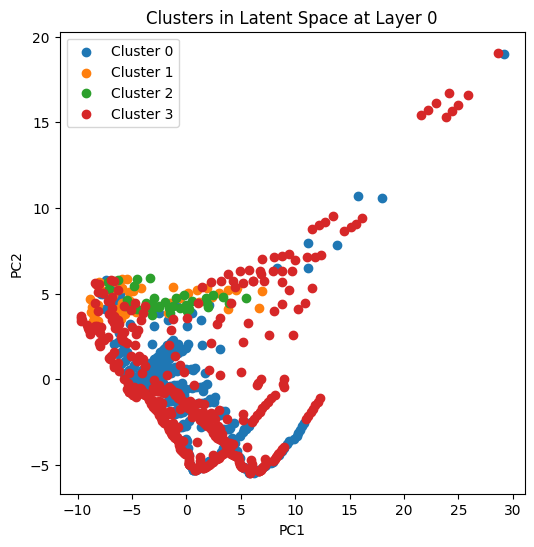

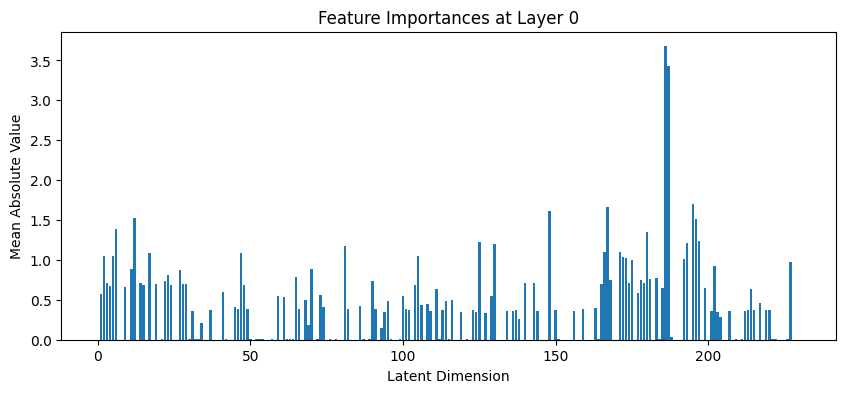

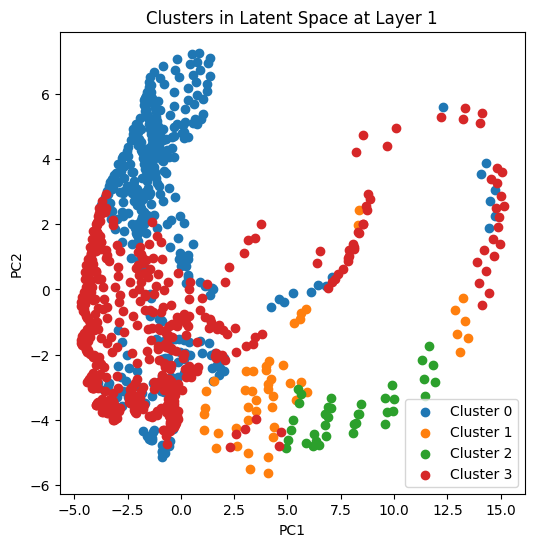

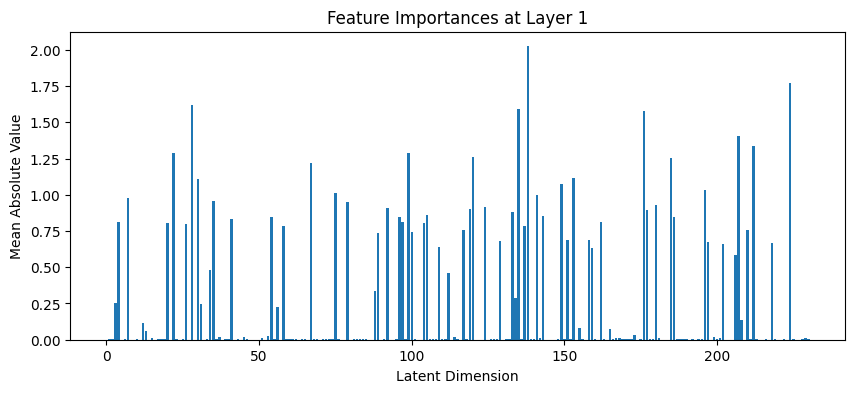

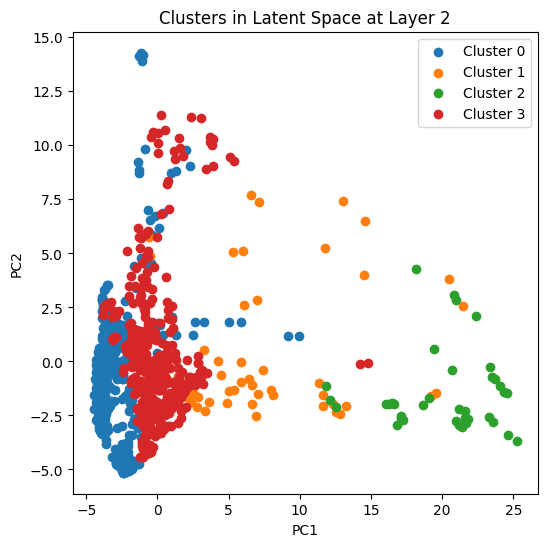

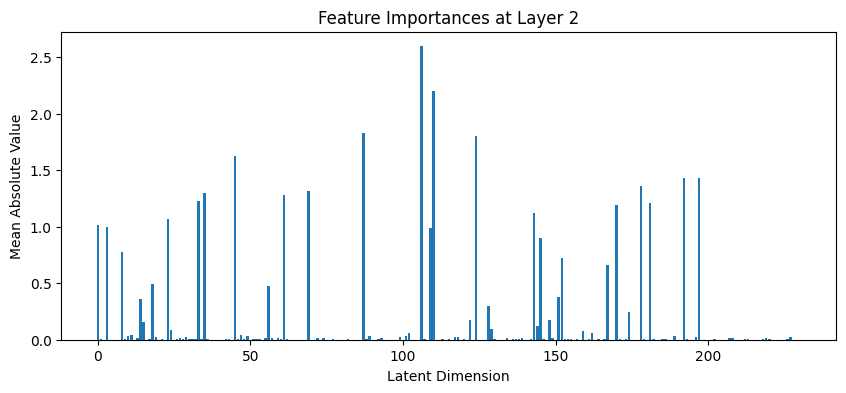

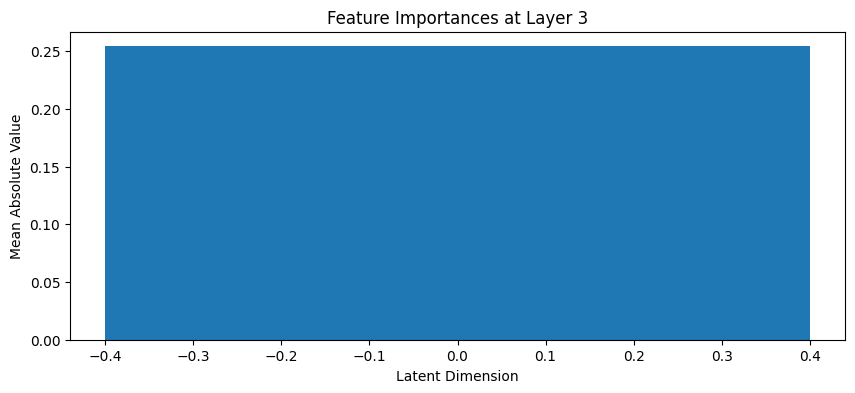

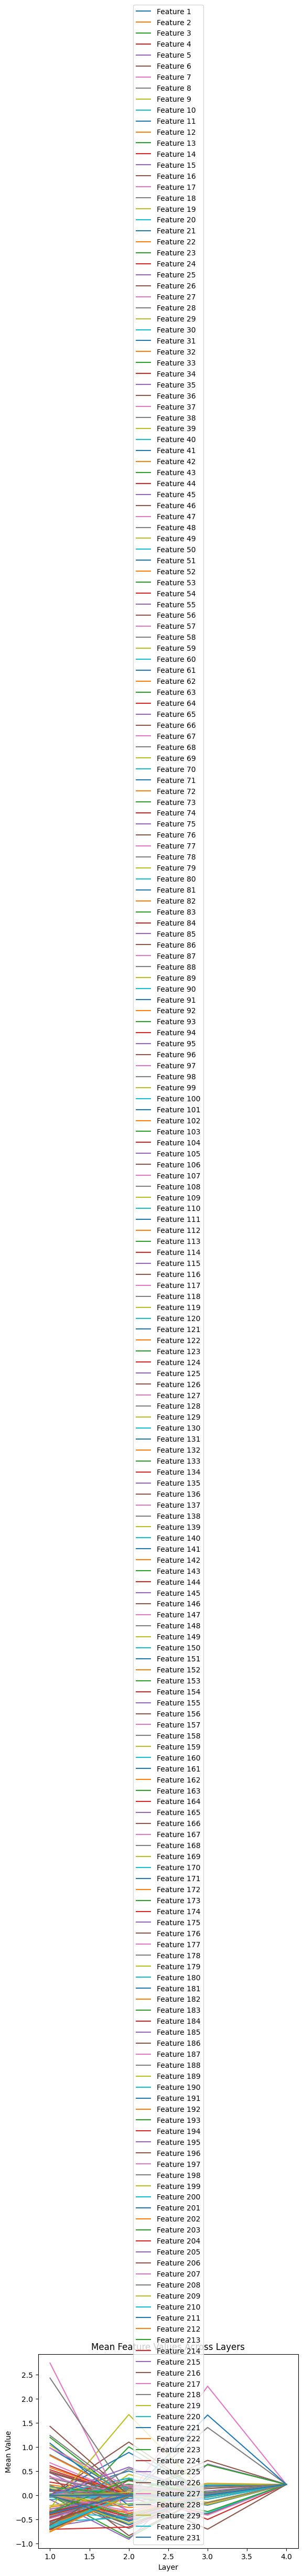

In [ ]:
from sklearn.decomposition import PCA


model.eval()
with torch.no_grad():
    output, latent_representations = model(data, return_latent_space=True)


# Analyze latent spaces
for i, latent in enumerate(latent_representations):
    latent_np = latent.cpu().numpy()

    latent_space_dim = latent_np.shape[1]
    # PCA Visualization
    pca = PCA(n_components=min(3, latent_space_dim))
    latent_pca = pca.fit_transform(latent_np)

    if latent_space_dim > 1:
        plt.figure(figsize=(6, 6))
        for c in range(num_clusters):
            plt.scatter(latent_pca[clusters == c, 0], latent_pca[clusters == c, 2], label=f'Cluster {c}')
        plt.title(f'Clusters in Latent Space at Layer {i}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.show()

    # Compute feature importances
    feature_importance = np.mean(np.abs(latent_np), axis=0)

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title(f'Feature Importances at Layer {i}')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Absolute Value')
    plt.show()



# Assuming all latent representations have the same feature dimensions
num_layers = len(latent_representations)
num_features = latent_representations[0].shape[1]

# Compute mean and standard deviation for each feature across layers
feature_means = np.zeros((num_layers, num_features))
feature_stds = np.zeros((num_layers, num_features))

for i, latent in enumerate(latent_representations):
    latent_np = latent.cpu().numpy()
    feature_means[i] = np.mean(latent_np, axis=0)
    feature_stds[i] = np.std(latent_np, axis=0)

# Plot mean feature values across layers
for f in range(num_features):
    plt.plot(range(1, num_layers + 1), feature_means[:, f], label=f'Feature {f+1}')

plt.title('Mean Feature Values Across Layers')
plt.xlabel('Layer')
plt.ylabel('Mean Value')
plt.legend()
plt.show()








tip index 0.43737295269966125 0.3062518239021301


[[ 11  13  28  30  41  43  49  58  71  73  88 118 144 146 148 178 193 195
  206 208 223 268 274 298 373 463 493 499 521 523 538 553 626 628 656 658
  718 748 853]]


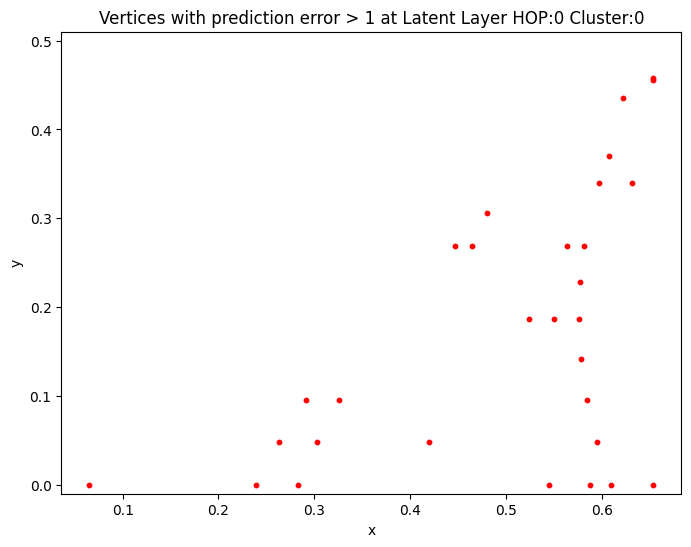

[[  0   9  11  13  21  26  28  30  41  43  58  69  71  73  86  88 116 118
  144 146 148 178 186 188 193 206 208 214 216 218 223 238 246 268 298 313
  371 373 411 413 433 439 441 443 461 463 471 478 491 493 521 523 538 551
  553 626 628 636 638 654 656 658 664 666 668 673 688 718 748 763 853 861
  863 883 889 891 893]]


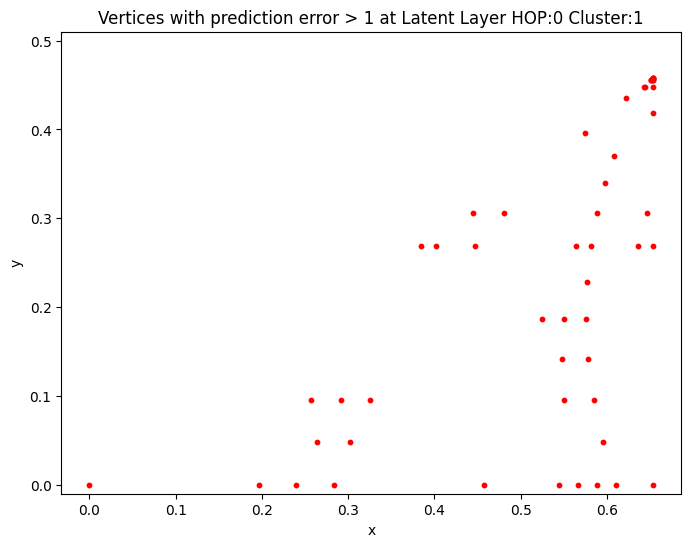

[[  0   7   9  11  26  28  30  39  41  56  69  71  77  86 116 144 146 161
  206 223 296 302 371 459 461 476 491 521 527 551 624 626 654 656 746 752
  851]]


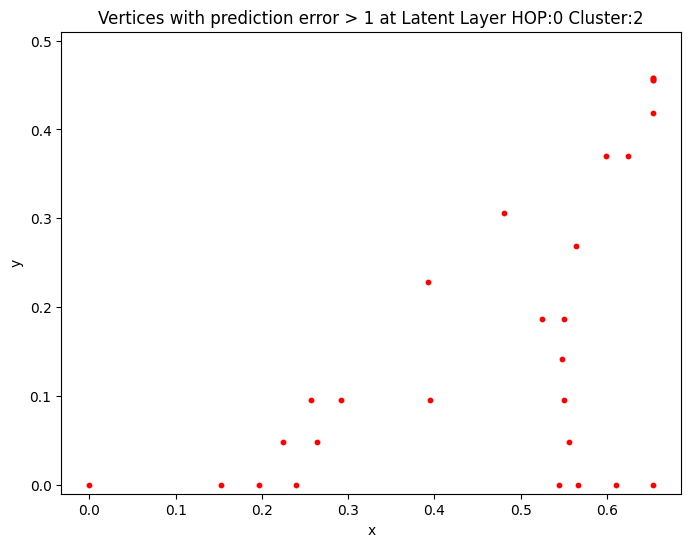

[[  7   9  11  17  19  21  26  28  37  39  41  49  56  69  71  84  86 116
  144 146 159 161 191 206 214 216 221 236 242 244 246 266 274 296 326 371
  439 441 459 461 467 469 471 476 489 491 499 519 521 536 549 551 624 626
  652 654 656 664 666 686 716 746 776 851 879 881 889 891]]


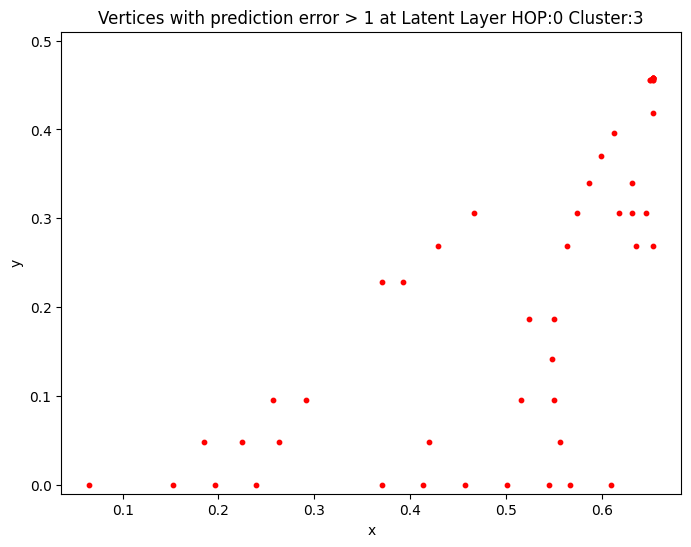

[[  5   7   9  24  26  28  35  37  39  54  67  69  84  86 105 114 144 157
  159 187 189 324 330 457 459 487 489 519 549 555 624 652 654 684 774 780
  879]]


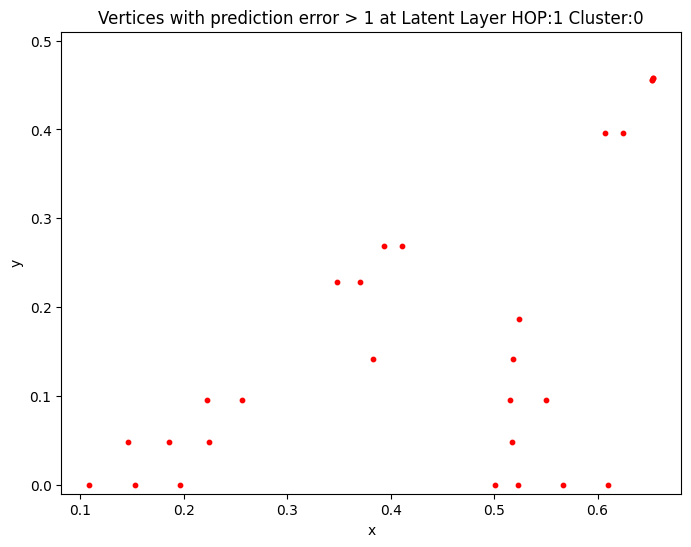

[[  5   7   9  17  19  24  28  33  35  37  39  45  47  49  54  56  65  67
   69  77  82  84  86 114 142 144 155 157 159 185 187 189 234 242 244 264
  270 272 274 294 302 324 369 457 459 467 469 485 487 489 495 497 499 504
  517 519 527 534 547 549 624 652 654 684 714 744 752 774 877 879]]


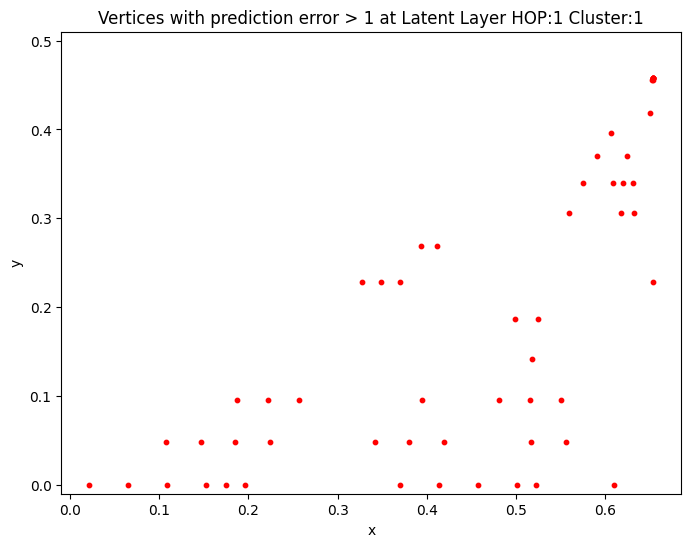

[[  5   7  33  35  37  54  56  63  65  67  82  84  86 133 142 155 157 185
  187 217 232 358 455 457 485 487 515 517 532 547 583 637 650 652 682 808
  877]]


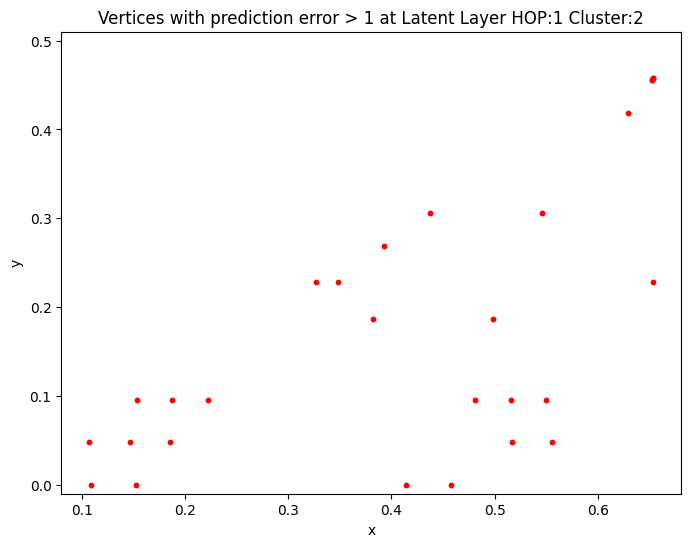

[[  5   7  22  31  33  35  37  45  47  52  63  65  67  73  75  77  82  84
  105 142 153 155 157 183 185 187 215 217 232 260 262 270 272 292 298 300
  302 322 330 412 455 457 483 485 487 495 497 515 517 523 525 527 532 545
  547 555 622 635 637 650 652 682 710 712 742 748 750 752 772 780 862 877]]


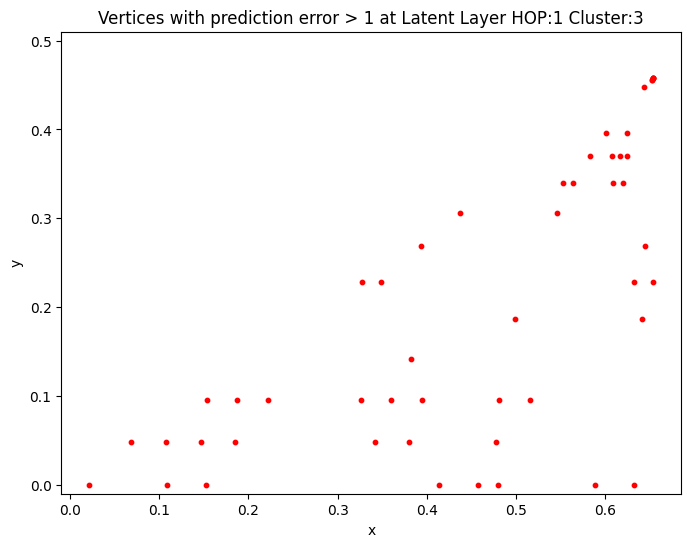

[[  5  18  20  31  33  35  61  63  65  80  82  84  91 142 153 155 161 183
  185 213 215 260 307 386 410 455 483 485 513 515 532 543 545 611 633 635
  650 665 710 740 836 860]]


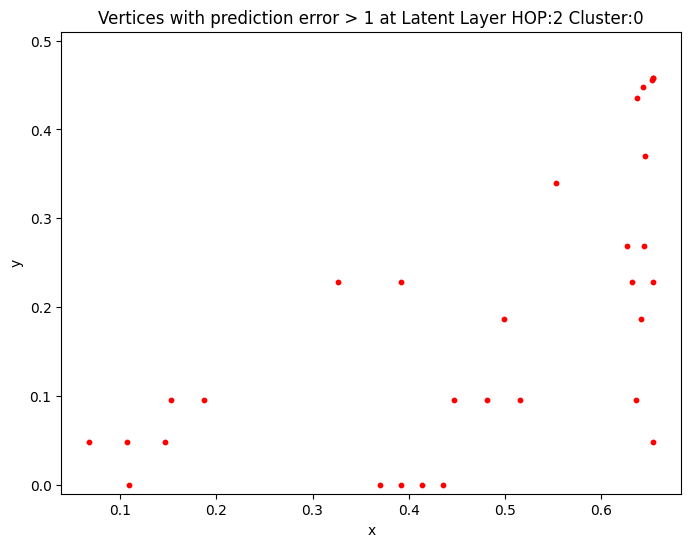

[[  3   5  16  18  20  31  33  35  61  63  65  73  75  80  84  89  91 101
  103 105 112 133 142 153 155 181 183 185 211 213 215 258 260 290 298 300
  320 326 328 330 358 410 455 483 485 513 515 523 525 541 543 545 551 553
  555 560 583 633 635 650 663 665 708 710 740 748 750 770 776 778 780 808
  860 875]]


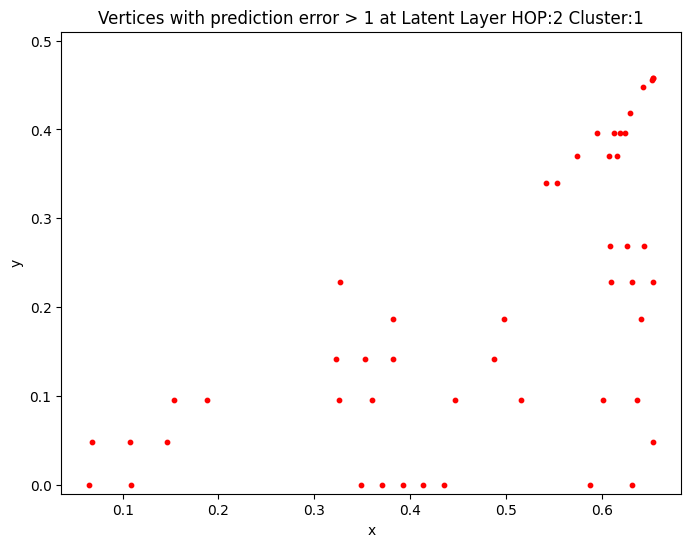

[[  3  16  18  31  33  48  61  63  89  91 112 119 140 142 151 153 168 181
  183 189 211 213 258 288 335 408 414 468 481 483 511 513 541 543 560 633
  639 663 708 738 858 864]]


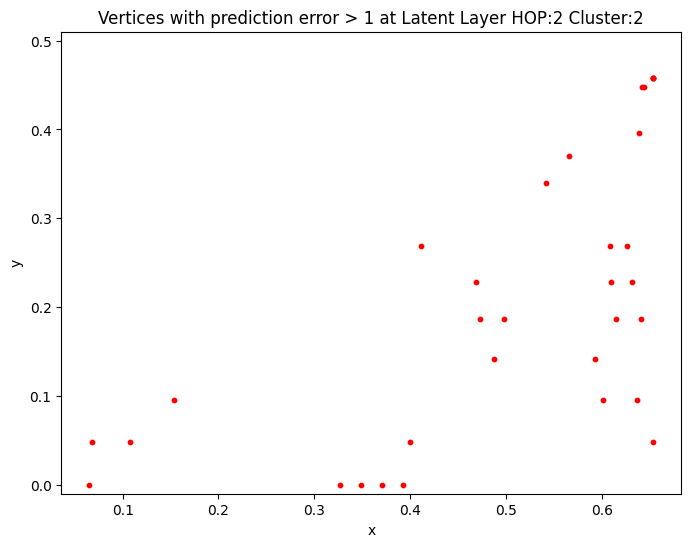

[[  3  14  16  18  31  33  46  48  61  63  78  87  89  91  93 101 103 119
  129 131 133 140 149 151 153 161 168 181 183 196 209 211 213 243 258 288
  316 318 326 328 354 356 358 386 408 438 453 466 468 481 483 511 513 539
  541 543 551 553 579 581 583 611 631 633 648 661 663 693 708 738 766 768
  776 778 804 806 808 836 858 888]]


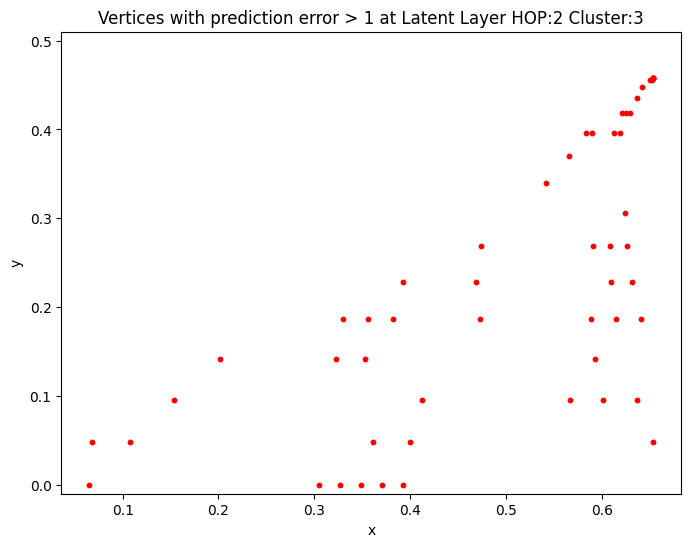

In [ ]:
# filter out the difference_storage_array y-index for error larger than 1 and plot on xy plane
vlm_location_x = test_set[test_index].vlm_vd.X
vlm_location_y = test_set[test_index].vlm_vd.Y
print(f"tip index {vlm_location_x[217]} {vlm_location_y[217]}")
# Create a scatter plot
fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter(
    x=vlm_location_x,
    y=vlm_location_y,
    mode='markers+text',
    text=array_index,
    textposition='top center',
    marker=dict(size=10, color='blue')
))

# Update layout for axis labels and figure size
fig.update_layout(
    width=800,  # Adjust as needed
    height=800,
    xaxis_title="x",
    yaxis_title="y",
    title="Interactive Scatter Plot",
)

# Show the plot
fig.show()

error_threshold = 1
for ilayer in range(0,12):
    error_index = np.where(difference_storage_array[:,ilayer] > error_threshold)
    error_index = np.array(error_index)
    print(error_index)
    # convert to 1D python array
    error_index = error_index.squeeze()
    vd_location_x = test_set[test_index].vlm_vd.X[error_index]
    vd_location_y = test_set[test_index].vlm_vd.Y[error_index]

    plt.figure(figsize=(8, 6))
    plt.scatter(vd_location_x, vd_location_y, c='r', s=10)
    plt.xlabel('x')
    plt.ylabel('y')
    ihop = int(np.floor(ilayer/4))
    icluster = ilayer % 4
    plt.title(f"Vertices with prediction error > {error_threshold} at Latent Layer HOP:{ihop} Cluster:{icluster}")
    plt.ylim(-0.01, 0.51)
    plt.show()